In [ ]:
# This notebook tests the making of pre-made masks for the Fizeau PSF FFT

# created 2018 July 16 by E.S.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numpy.ma as ma
import os.path
from scipy import misc, signal, ndimage
from astropy.io import fits
from matplotlib.colors import LogNorm
% matplotlib inline

In [2]:
from lmircam_tools import *
from lmircam_tools import overlap_psfs

In [3]:
# for starters, read in some real data and FFT the Fizeau/Airy PSFs

In [4]:
stem = ('/home/../../media/unasemaje/Seagate Expansion Drive/lbti_data_reduction/180507_fizeau_altair/01_fix_pixed/')

In [5]:
# set units of the observation

wavel_lambda = 3.7e-6 # meters
D = 8.25 # meters
B_c2c = 14.4 # meters
B_e2e = 22.65 # meters
plateScale = 0.0107 # asec/pixel
global asecInRad
asecInRad = 206264.81

In [6]:
# locations of Airy minima/maxima (units lambda/D)

max1 = 0
min1 = 1.220
max2 = 1.635
min2 = 2.233
max3 = 2.679
min3 = 3.238
max4 = 3.699

In [30]:
def findFFTloc(baseline,imageShapeAlong1Axis,wavel_lambda,plateScale,lOverD=1.):
    # baseline: distance in physical space in the pupil plane (in m)
    # imageShapeAlong1Axis: length of one side of the input image (needs to be square)
    # wavel_lambda: wavelength of light (in m)
    # plateScale: detector plate scale (in asec/pix)
    # lOverD: option if we are interested in the circular Airy rings (values 1.22, etc.)
    
    line_diam_pixOnScience = lOverD*(wavel_lambda*asecInRad)/(baseline*plateScale) # distance in pixels on science detector
    line_diam_freq = np.divide(1.,line_diam_pixOnScience) # the corresponding frequency
    line_diam_pixOnFFT_L = 0.5*imageShapeAlong1Axis - np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis)) # find number of 'frequency pixels' multiply by units of l/D (like 1.22), and add to central x frequency pixel
    line_diam_pixOnFFT_H = 0.5*imageShapeAlong1Axis + np.divide(line_diam_freq,np.divide(1.,imageShapeAlong1Axis)) # find number of 'frequency pixels' multiply by units of l/D (like 1.22), and add to central x frequency pixel
    
    return line_diam_pixOnFFT_L, line_diam_pixOnFFT_H # the lower and higher values around freq of zero

Working on frame 009400 ...
Working on frame 009401 ...
Working on frame 009402 ...
Working on frame 009403 ...
Working on frame 009404 ...
Working on frame 009405 ...
Working on frame 009406 ...
Working on frame 009407 ...
Working on frame 009408 ...
Working on frame 009409 ...
Working on frame 009410 ...
Working on frame 009411 ...
Working on frame 009412 ...
Working on frame 009413 ...
Working on frame 009414 ...
Working on frame 009415 ...
Working on frame 009416 ...
Working on frame 009417 ...
Working on frame 009418 ...
Working on frame 009419 ...
Working on frame 009420 ...
Working on frame 009421 ...
Working on frame 009422 ...
Working on frame 009423 ...
Working on frame 009424 ...
Working on frame 009425 ...
Working on frame 009426 ...
Working on frame 009427 ...
Working on frame 009428 ...
Working on frame 009429 ...
Working on frame 009430 ...
Working on frame 009431 ...
Working on frame 009432 ...
Working on frame 009433 ...
Working on frame 009434 ...
Working on frame 009

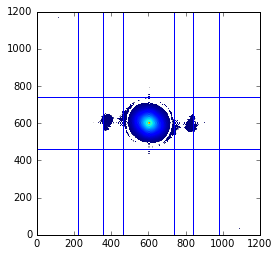

In [44]:
# for loop to take cookie cut-outs of Fizeau/Airy PSFs, and take FFTs

ampArray = []
for f in range(9400,9500):  # 9510

    filename_str = stem+'lm_180507_'+str("{:0>6d}".format(f))+'.fits'
    
    if os.path.isfile(filename_str): # if FITS file exists in the first place
    
        print('Working on frame '+str("{:0>6d}".format(f))+' ...')
        
        image, header = fits.getdata(filename_str,0,header=True) 
        
        # a perfect PSF
        #image, header = fits.getdata(stem+'perfect_psf.fits',0,header=True) 
    
        # locate PSF
        psf_loc = overlap_psfs.find_airy_psf(image)
        #print(psf_loc)
    
        # size of cookie cut-out (measured center-to-edge)
        cookie_size = 100 # maximum control radius as of 2018 July corresponds to 130.0 pixels
    
        # take FFT
        cookie_cut = image[psf_loc[0]-cookie_size:psf_loc[0]+cookie_size,psf_loc[1]-cookie_size:psf_loc[1]+cookie_size]
        amp, arg = fft_img(cookie_cut).fft(padding=int(5*cookie_size), mask_thresh=1e5)
    
        #print(np.shape(cookie_cut))
    
        #plt.imshow(cookie_cut)
        #plt.show()
    
        if (np.shape(amp)[0]!=np.shape(amp)[1]): # if the FFT doesn't make sense (i.e., if PSF was not found)
            print('PSF does not make sense ... aborting this one ...')
            continue
            
        # make division lines separating different parts of the PSF
        line_M1diam_pixOnFFT = findFFTloc(8.25,np.shape(amp)[0],wavel_lambda,plateScale)
        line_center2center_pixOnFFT = findFFTloc(14.4,np.shape(amp)[0],wavel_lambda,plateScale)
        line_edge2edge_pixOnFFT = findFFTloc(22.65,np.shape(amp)[0],wavel_lambda,plateScale)    
    
    
        #plt.imshow(cookie_cut, origin='lower')
        #plt.show()
            
        plt.clf()
        plt.imshow(amp, origin="lower")
        plt.axhline(line_M1diam_pixOnFFT[0])
        plt.axhline(line_M1diam_pixOnFFT[1])
        plt.axvline(line_M1diam_pixOnFFT[0])
        plt.axvline(line_M1diam_pixOnFFT[1])
        plt.axvline(line_center2center_pixOnFFT[0])
        plt.axvline(line_center2center_pixOnFFT[1])
        plt.axvline(line_edge2edge_pixOnFFT[0]) 
        plt.axvline(line_edge2edge_pixOnFFT[1]) 
        
        highFreqNode = amp[line_M1diam_pixOnFFT[0]:line_M1diam_pixOnFFT[1],line_M1diam_pixOnFFT[1]:line_edge2edge_pixOnFFT[1]]
        
        ampArray = np.concatenate((ampArray, [np.median(highFreqNode)]))
        
        #plt.clf()
        #plt.imshow(highFreqNode)
        #plt.show()
        
        
        
    
        #plt.savefig("images/psf_altair_fft_check_"+str("{:0>6d}".format(f))+".png", dpi=300, overwrite=False)
        #plt.savefig("images/test.pdf", dpi=300, overwrite=True)
        #plt.clf()

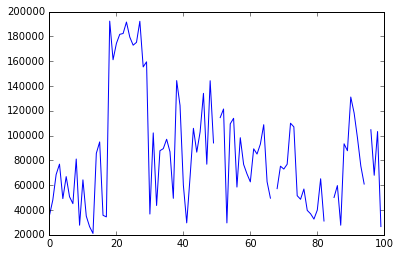

In [45]:
plt.plot(ampArray)
plt.show()

In [ ]:
# how are FFTs affected by
# 1. fringe movement
# 2. changing visibility
# 3. stuff listed in my table

# ... and how good am I at finding the center of the PSF?

In [ ]:
# based on the images, decide whether to move HPC in piston, tip, tilt
# iterate?
# maybe I don't want to move HPC in piston, because I found the center of the envelope with the grism,
# and Phasecam isn't closed yet